### **Installation**

In [2]:
pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 47.2 MB/s eta 0:00:00
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2


In [3]:
#pip install amazon-braket-pennylane-plugin

In [4]:
# pip install pennylane-qiskit

### **Libs**

In [5]:
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import NesterovMomentumOptimizer
import numpy as np
from numpy.random import sample
import matplotlib.pyplot as plt
# import qiskit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# import torch
# from torch import nn
# import torchvision
# from torchvision import transforms
# from torch.utils.data import TensorDataset, DataLoader

import matplotlib as mpl
import sklearn
from sklearn import datasets
import seaborn as sns
import pandas as pd
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings("ignore")

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# import boto3

# session = boto3.Session(region_name='us-west-1')
# s3_client = session.client('s3')

### **Quantum Circuit**

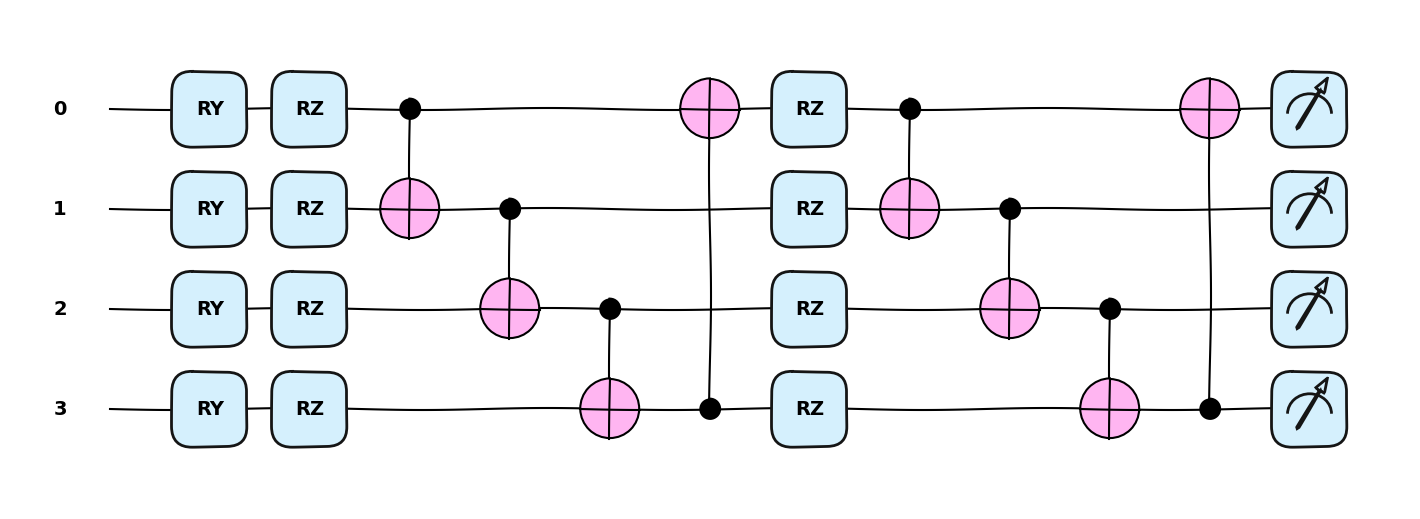

In [6]:
num_wires = 4
n_layer = 2
dev = qml.device("lightning.qubit", wires=num_wires)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layer, num_wires))
@qml.qnode(dev, interface="autograd")
def qconv(phi):
    # Encoding of 4 classical input values
    for j in range(num_wires):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    # qml.RandomLayers(rand_params,ratio_imprim=0.3, wires=list(range(num_wires)))
    # qml.StronglyEntanglingLayers(rand_params, imprimitive=qml.ops.CZ,wires=list(range(num_wires)))
    qml.BasicEntanglerLayers(rand_params,wires=list(range(num_wires)),rotation=qml.RZ)

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(num_wires)]
ip =  [np.random.rand(num_wires)]
fig, ax = qml.draw_mpl(qconv,style='pennylane',expansion_strategy='device')(*ip)
plt.show()

### **Quanvolution**

In [7]:
def quanv(image, out_channels=num_wires, kernel_size=2, stride=2):
    h, w, ch = image.shape
    filters = 1
    h_out = (h - kernel_size) // stride + 1
    w_out = (w - kernel_size) // stride + 1

    # Reshape the input image into blocks for batch processing
    image_blocks = np.lib.stride_tricks.sliding_window_view(image, (kernel_size, kernel_size, ch))
    image_blocks = image_blocks[::stride, ::stride]

    # Flatten the blocks for batch processing
    image_blocks = image_blocks.reshape(-1, kernel_size * kernel_size * ch)

    # Apply the quantum circuit to all blocks in a batch
    q_results=[]
    for i in range(len(image_blocks)):
      q_results.append(qconv(image_blocks[i]))

    # Reshape the results to match the output shape
    q_results = np.asarray(q_results).reshape(h_out, w_out, out_channels)

    if filters > 1:
        q_results = np.repeat(q_results, filters, axis=-1)

    return q_results

In [8]:
# Quantum pre-processing of the training, validation, and test datasets
def quantum_preprocessing(images):
    q_images = []
    for img in images:
        q_images.append(quanv(img))
    return np.asarray(q_images)

### **Digits Dataset**

In [94]:
def load_digits_data_2():
    """Return training and testing data of digits dataset."""
    digits = datasets.load_digits()
    # dat = sample(digits,n)
    features, labels = digits.data, digits.target

    # only use first two classes
    features = features
    labels = labels
    features = features / np.linalg.norm(features, axis=1).reshape((-1, 1))
    x_train,x,y_train,y = train_test_split(features,labels,test_size=0.3,random_state=2)
    x_val,x_test,y_val,y_test = train_test_split(x,y,test_size=0.5,random_state=2)

    x_train = x_train.reshape(len(x_train), 8, 8)
    # Reshape the label
    y_train = y_train.reshape(len(y_train))
    # y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
    x_val = x_val.reshape(len(x_val), 8, 8)
    y_val = y_val.reshape(len(y_val))
    x_test = x_test.reshape(len(x_test), 8, 8)
    y_test = y_test.reshape(len(y_test))
    x_train = pnp.array(x_train[..., tf.newaxis], requires_grad=False)
    x_val = pnp.array(x_val[..., tf.newaxis], requires_grad=False)
    x_test = pnp.array(x_test[..., tf.newaxis], requires_grad=False)
    return (x_train,x_val,y_train,y_val,x_test,y_test)

In [95]:
x_train,x_val,y_train,y_val,x_test,y_test = load_digits_data_2()

### **Fashion MNIST**

In [9]:
def load_fmnist(n_train,n_val):
    """Return training and testing data of digits dataset."""
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()
    # dat = sample(digits,n)

    x_train = x_train[:n_train]
    y_train = y_train[:n_train]
    x_val = x_val[:n_val]
    y_val = y_val[:n_val]


    x_train = x_train / 255
    x_val = x_val / 255
    x_vali,x_test,y_vali,y_test = train_test_split(x_val,y_val,test_size=0.5,random_state=2)

    # Add extra dimension for convolution channels
    # x_train = tf.image.resize(x_train.T, [8, 8]).numpy().T
    # x_vali = tf.image.resize(x_vali.T, [8, 8]).numpy().T
    # x_test = tf.image.resize(x_test.T, [8, 8]).numpy().T

    x_train = pnp.array(x_train[..., tf.newaxis], requires_grad=False)
    x_vali = pnp.array(x_vali[..., tf.newaxis], requires_grad=False)
    x_test = pnp.array(x_test[..., tf.newaxis], requires_grad=False)
    return (x_train,x_vali,y_train,y_vali,x_test,y_test)

In [10]:
x_train,x_val,y_train,y_val,x_test,y_test = load_fmnist(500,300)

4422102/4422102 [==============================] - 0s 0us/step


Text(0.5, 1.0, 'Original')

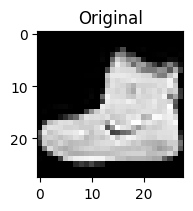

In [11]:
plt.subplot(1, 3, 1)
plt.imshow(x_train[0], cmap='gray')
plt.title('Original')

# # Plot the resized image
# plt.subplot(1, 3, 2)
# plt.imshow(x_train_resized[4], cmap='gray')
# plt.title('Resized (8x8)')

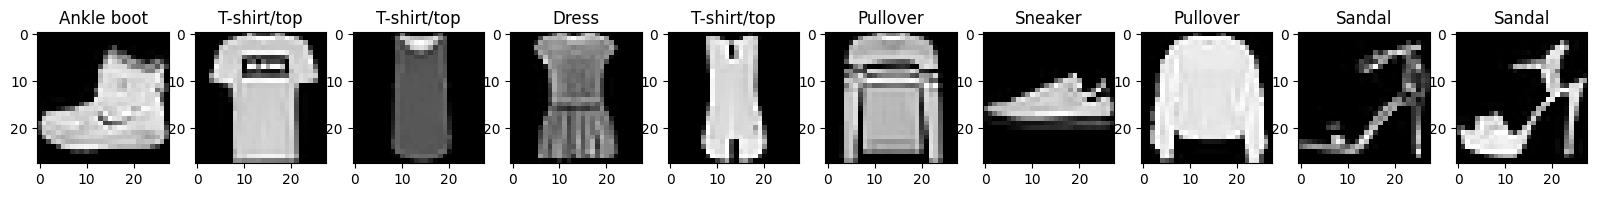

In [105]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(x_train[i], cmap='gray')
    ax[i].set_title(labeldict[y_train[i]])

### **Quantum Preprocess**

In [12]:
# Quantum pre-processing of the training dataset
q_train_images = quantum_preprocessing(x_train)

# Quantum pre-processing of the validation dataset
q_val_images = quantum_preprocessing(x_val)

# Quantum pre-processing of the test dataset
q_test_images = quantum_preprocessing(x_test)

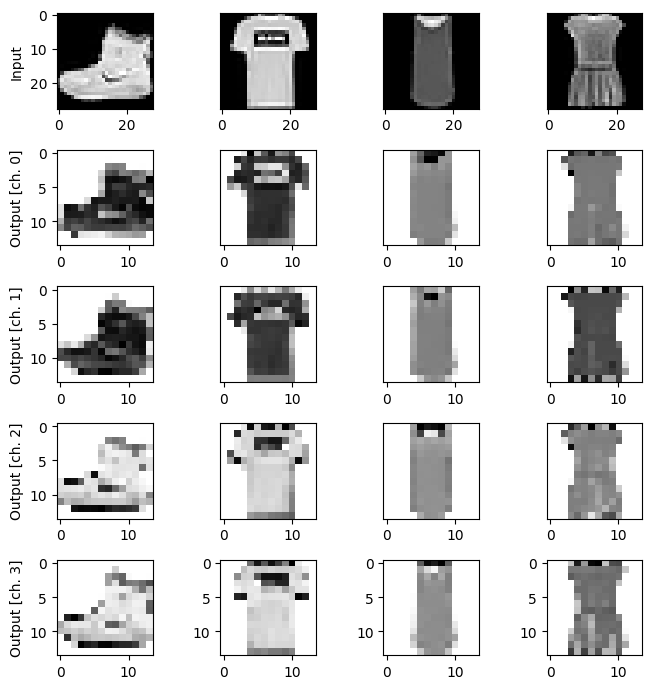

In [13]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(7, 7))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(x_train[k, :, :, 0],cmap='gray')

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c],cmap='gray')

plt.tight_layout()
plt.show()

### **Other functions**

In [14]:
def plot(history,quantum = True):
  # Plot the loss and accuracy curves for training and validation
  fig, ax = plt.subplots(1,2, figsize=(8,4))
  ax[0].plot(history.history['loss'], color='b', label="Training loss")
  ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
  legend = ax[0].legend(loc='best', shadow=True)

  ax[1].plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
  ax[1].plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
  legend = ax[1].legend(loc='best', shadow=True)

  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  plt.suptitle('Quanvolutional Neural Network',fontsize=15)
  if quantum == False:
    plt.suptitle('Convolutional Neural Network',fontsize=15)

In [15]:
def metrics(model,history,quantum=True):
  accuracy = np.mean(history.history['categorical_accuracy'][-10:])
  val_accuracy = np.mean(history.history['val_categorical_accuracy'][-10:])
  loss = np.mean(history.history['loss'][-10:])
  val_loss = np.mean(history.history['val_loss'][-10:])
  if quantum == True:
    test = q_test_images
  else:
    test = x_test
  test_evaluation = model.evaluate(test,to_categorical(y_test))
  labeldict = {
    'Training Accuracy': accuracy,
    'Training Loss': loss,
    'Validation Accuracy': val_accuracy,
    'Validation Loss': val_loss,
    # test_evaluation: 'Test Evaluation',
  }
  return labeldict

### **QNN vs CNN model - Digits**

In [35]:
def model():
  flat = layers.Flatten()
  pool = layers.MaxPool2D((1,1))
  clayer1 = layers.Dense(64,activation='elu',name='d1')
  bn = layers.BatchNormalization()
  conv = layers.Conv2D(16,kernel_size=1,input_shape=[4,4,4])
  clayer2 = layers.Dense(64,activation='elu',name='d2')
  clayer3 = layers.Dense(16,activation='elu',name='d3')
  drop1 = layers.Dropout(0.2)
  drop2 = layers.Dropout(0.2)
  clayer4 = layers.Dense(10, activation="softmax",name='d4')
  # model = keras.Sequential([flat, clayer1,bn, drop, clayer2 ,drop, clayer3,bn,drop, clayer4])
  model = keras.Sequential([conv,pool,flat,clayer2,drop1,clayer3,clayer4])

  opt = tf.keras.optimizers.Adam(learning_rate=0.01)
  model.compile(optimizer = opt, loss='categorical_crossentropy',
  metrics=["categorical_accuracy"])
  return model

In [36]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,min_delta=0.001, restore_best_weights=True)
q_model = model()

In [ ]:
history = q_model.fit(x=q_train_images,y=to_categorical(y_train), validation_data = (q_val_images,to_categorical(y_val)),epochs=100,batch_size=100,verbose=None,callbacks=[callback])

In [ ]:
q_model.summary()

Text(0, 0.5, 'Accuracy')

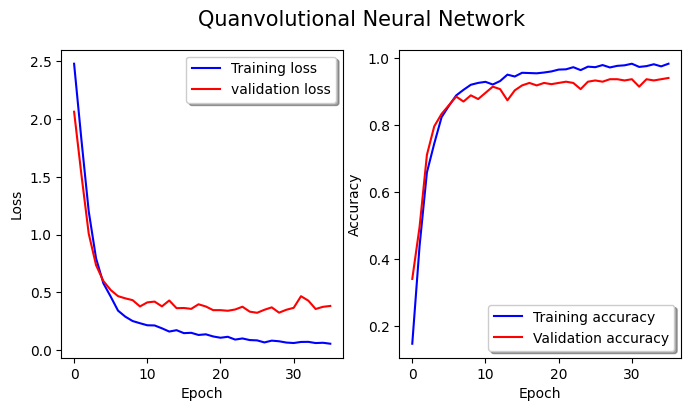

In [39]:
plot(history)

In [ ]:
metrics(q_model,history)

In [20]:
def cnn_model():
  layer1 = layers.Conv2D(16,kernel_size=2,activation='relu',padding='same',input_shape=([8,8,1]))
  layer2 = layers.MaxPool2D((2,2))

  layer3 = layers.Conv2D(16,kernel_size=1,activation='relu',padding='same',trainable=False)
  layer4 = layers.MaxPool2D((2,2))

  # layer5 = layers.Conv2D(128,kernel_size=2,activation='relu',padding='same')
  # layer6 = layers.Conv2D(128,kernel_size=2,activation='relu',padding='same')
  # layer7 = layers.MaxPool2D((2,2))

  layer8 = layers.Flatten()
  layer12 = layers.Dense(32,activation='elu')
  layer9 = layers.Dense(16,activation='elu')
  drop1 = layers.Dropout(0.2)
  drop2 = layers.Dropout(0.2)
  layer11 = layers.Dense(10,activation = 'softmax')
  # ,layer5,layer6,layer7,layer4
  model = keras.Sequential([layer1,layer2,layer3,layer8,layer12,drop1,layer9,layer11])
  # model = keras.Sequential([layer1,layer2,layer3])
  opt = tf.keras.optimizers.Adam(learning_rate=0.01)
  c_model.compile(optimizer = opt, loss='categorical_crossentropy',
             metrics=["categorical_accuracy"])
  return model

In [21]:
c_model = cnn_model()

In [ ]:
history_c = c_model.fit(x=x_train,y=to_categorical(y_train), validation_data = (x_val,to_categorical(y_val)),epochs=100,batch_size=100,verbose=None,callbacks=[callback])

In [ ]:
c_model.summary()

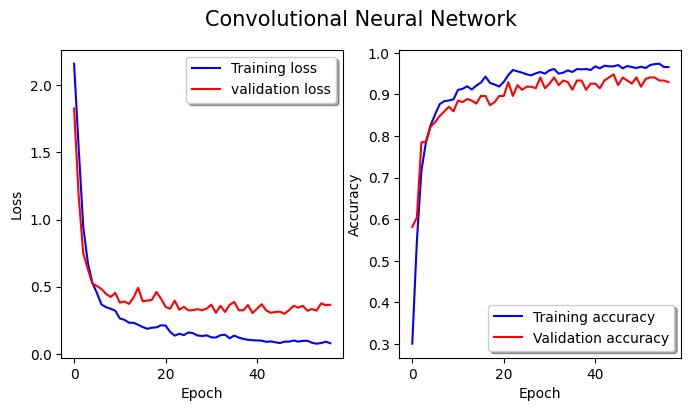

In [79]:
plot(history_c,quantum=False)

In [98]:
metrics(c_model,history_c,quantum=False)

9/9 [==============================] - 0s 7ms/step - loss: 0.1388 - categorical_accuracy: 0.9519


{'Training Accuracy': 0.9676213324069977,
 'Training Loss': 0.0887036681175232,
 'Validation Accuracy': 0.9333333432674408,
 'Validation Loss': 0.34671750366687776}

### **QNN vs CNN model - Fashion MNIST**

In [273]:
def model():
  flat = layers.Flatten()
  pool = layers.MaxPool2D((1,1))
  bn = layers.BatchNormalization()
  conv = layers.Conv2D(16,kernel_size=1,activation='relu',input_shape=[14,14,4])
  clayer2 = layers.Dense(128,activation='relu',name='d2')
  bn1 = layers.BatchNormalization()
  clayer3 = layers.Dense(48,activation='relu',name='d3')
  drop1 = layers.Dropout(0.25)
  drop2 = layers.Dropout(0.2)
  bn2 = layers.BatchNormalization()
  clayer4 = layers.Dense(16,activation='relu',name='d4')
  clayer5 = layers.Dense(10, activation="softmax",name='d5')
  model = keras.Sequential([conv,pool,flat,clayer2,drop1,bn,clayer3,clayer5])

  opt = tf.keras.optimizers.Adam(learning_rate=0.01)
  model.compile(optimizer = opt, loss='categorical_crossentropy',
  metrics=["categorical_accuracy"])
  return model

In [274]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15,min_delta=0.001, restore_best_weights=True)
q_model = model()

In [275]:
history = q_model.fit(x=q_train_images,y=to_categorical(y_train), validation_data = (q_val_images,to_categorical(y_val)),epochs=50,batch_size=100,verbose=None,callbacks=[callback])

In [276]:
q_model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 14, 14, 16)        80        
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_43 (Flatten)        (None, 3136)              0         
                                                                 
 d2 (Dense)                  (None, 128)               401536    
                                                                 
 dropout_86 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_112 (B  (None, 128)               512       
 atchNormalization)                                  

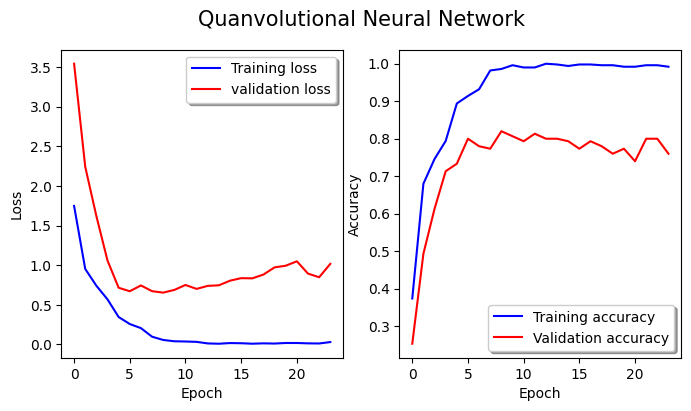

In [277]:
plot(history)

In [278]:
metrics(q_model,history)

5/5 [==============================] - 0s 4ms/step - loss: 0.9496 - categorical_accuracy: 0.7267


{'Training Accuracy': 0.9949999988079071,
 'Training Loss': 0.01532073924317956,
 'Validation Accuracy': 0.7773333311080932,
 'Validation Loss': 0.9125150442123413}

In [243]:
def cnn_model():
  layer1 = layers.Conv2D(16,kernel_size=2,activation='relu',padding='same',input_shape=([28,28,1]))
  layer2 = layers.MaxPool2D((2,2))

  layer3 = layers.Conv2D(16,kernel_size=1,activation='relu',padding='same',trainable=False)
  layer4 = layers.MaxPool2D((2,2))

  # layer5 = layers.Conv2D(128,kernel_size=2,activation='relu',padding='same')
  # layer6 = layers.Conv2D(128,kernel_size=2,activation='relu',padding='same')
  # layer7 = layers.MaxPool2D((2,2))
  bn1 = layers.BatchNormalization()
  bn2 = layers.BatchNormalization()
  layer8 = layers.Flatten()
  layer12 = layers.Dense(128,activation='relu')
  layer = layers.Dense(32,activation='relu')
  layer9 = layers.Dense(16,activation='relu')
  drop1 = layers.Dropout(0.3)
  drop2 = layers.Dropout(0.2)
  layer11 = layers.Dense(10,activation = 'softmax')
  # ,layer5,layer6,layer7,layer4
  model = keras.Sequential([layer1,layer2,layer8,layer12,drop1,bn1,layer,layer11])
  # model = keras.Sequential([layer1,layer2,layer3])
  opt = tf.keras.optimizers.Adam(learning_rate=0.01)
  model.compile(optimizer = opt, loss='categorical_crossentropy',
             metrics=["categorical_accuracy"])
  return model

In [207]:
c_model = cnn_model()

In [208]:
history_c = c_model.fit(x=x_train,y=to_categorical(y_train), validation_data = (x_val,to_categorical(y_val)),epochs=50,batch_size=100,verbose=None,callbacks=[callback])

In [209]:
c_model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 28, 28, 16)        80        
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_32 (Flatten)        (None, 3136)              0         
                                                                 
 dense_32 (Dense)            (None, 128)               401536    
                                                                 
 dropout_64 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_80 (Ba  (None, 128)               512       
 tchNormalization)                                   

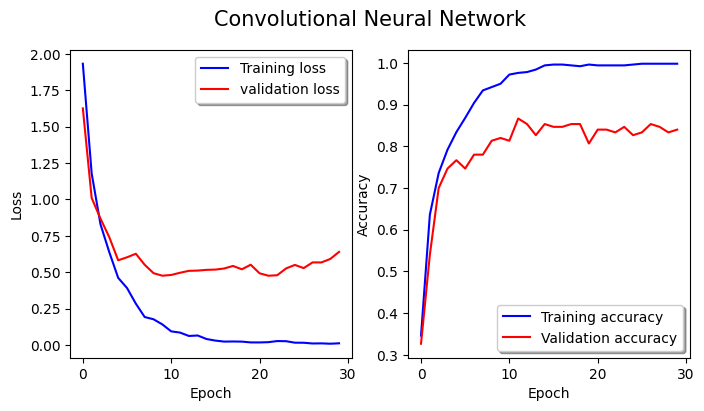

In [210]:
plot(history_c,quantum=False)

In [211]:
metrics(c_model,history_c,quantum=False)

5/5 [==============================] - 0s 5ms/step - loss: 0.6470 - categorical_accuracy: 0.7733


{'Training Accuracy': 0.9962000191211701,
 'Training Loss': 0.01643397444859147,
 'Validation Accuracy': 0.8393333256244659,
 'Validation Loss': 0.5415843546390533}